In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Generate Data

In [7]:
d_num = int(1e4)

t_list = [i/100 for i in range(d_num)]
sin_list = [math.sin(t) for t in t_list]

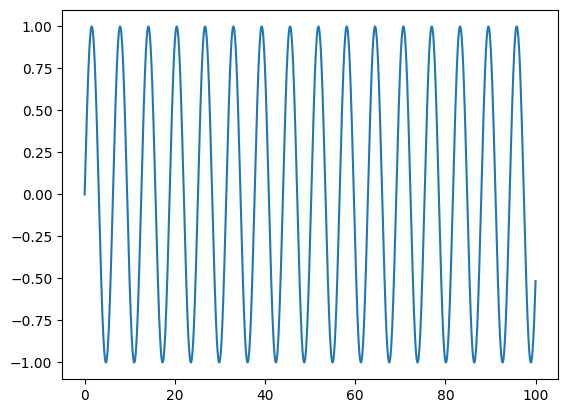

In [10]:
plt.plot(t_list, sin_list)

# Modeling

## libs

In [34]:
def visualize_results(prediction_matrix: np.array, target_matrix: np.array, timeline=list, save_dir=str):
    for i, (p, t) in enumerate(zip(prediction_matrix, target_matrix)):
        plt.figure(figsize=[12, 6])
        plt.title(f"HOUSE {i+1:02d} PREDICTION")
        plt.plot(timeline, p, label='prediction')
        plt.plot(timeline, t, label='target')
        plt.legend()
        plt.xlabel('Datetime')
        plt.ylabel('Usage of electricity')
        plt.savefig(save_dir + f'prediction_{i+1:02d}.png')

## pre-processing

In [91]:
import random
input_dim = int(10)
dataset_num = d_num-input_dim

xy_list = [(np.array(sin_list[i:i+input_dim]), np.array(sin_list[i+input_dim])) for i in range(dataset_num)]
random.shuffle(xy_list)

In [92]:
train_data = xy_list[:dataset_num*8//10]
valid_data = xy_list[dataset_num*8//10:dataset_num*9//10]
test_data = xy_list[dataset_num*9//10:]

In [93]:
len(train_data), len(valid_data), len(test_data)

(7992, 999, 999)

In [94]:
train_dataset = train_data
valid_dataset = valid_data
test_dataset = test_data

train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=100)
test_loader = DataLoader(dataset=test_dataset, batch_size=100)

linear_input_dim = len(train_dataset[0][0])
lstm_input_dim = 1

## model modeling

In [95]:
import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader


In [96]:
input_dim = int(1e2)
num_layers = 3

class sin_LSTM(nn.Module):
#     def __init__(self, input_dim=input_dim, embedding_dim=100, lstm_hidden_dim=128, output_dim=1, num_layers=num_layers, bidirectional=False):
    def __init__(self, input_dim=input_dim, lstm_hidden_dim=128, output_dim=1, num_layers=num_layers, bidirectional=False):
        super().__init__()

        self.output_dim = output_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.lstm_dim = lstm_hidden_dim
        self.hidden_dim = self.lstm_dim

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

        self.bn0 = nn.BatchNorm1d(self.hidden_dim // 2)
        self.bn1 = nn.BatchNorm1d(self.hidden_dim // 4)

        self.fc0 = nn.Linear(self.hidden_dim, self.hidden_dim // 2)
        self.fc1 = nn.Linear(self.hidden_dim // 2, self.hidden_dim // 4)
        self.fc2 = nn.Linear(self.hidden_dim // 4, output_dim)

    def forward(self, seq_x):
        _, (h_t, c_t) = self.lstm(seq_x.unsqueeze(dim=-1).float())
        output = h_t
        print(output.shape)
        print(self.hidden_dim)
        output = self.relu(self.bn0(self.fc0(output)))
        output = self.relu(self.bn1(self.fc1(output)))
        output = self.fc2(output)

        return output

## training

In [97]:
from sklearn.metrics import mean_absolute_percentage_error
from tqdm import tqdm

def Train(model, train_loader, valid_loader, n_epochs, optimizer, criterion, device, path):
    """
    path: path to save model
    Returns: model, avg_train_loss, avg_train_mape, avg_valid_loss, avg_valid_mape
    """
    avg_train_loss, avg_train_mape = [], []
    avg_valid_loss, avg_valid_mape = [], []
    best_loss, best_mape = np.inf, np.inf
    # patience = 0

    for epoch in range(1, n_epochs + 1):
        train_rmse_losses, valid_rmse_losses = [], []
        train_mape, valid_mape = [], []

        # TRAIN
        model.train()
        for iter, (seq_x, y) in tqdm(enumerate(train_loader)):
            optimizer.zero_grad()
            output = model(seq_x.to(device))
            predicted = output.squeeze().detach()

            # calculatemape
            mape = mean_absolute_percentage_error(y, predicted.cpu())
            train_mape.append(mape)

            # calculate loss
            loss = criterion(output.squeeze().cpu().float(), y.float())
            loss.backward()
            optimizer.step()
            train_rmse_losses.append(loss.item()**0.5)
            if 'cuda' in device:
                torch.cuda.empty_cache()

            if iter > 300:
                break

        # VALIDATION
        model.eval()
        with torch.no_grad():
            for house_x, seq_x, y in valid_loader:

                output = model(seq_x.to(device))
                predicted = output.squeeze().detach()

                mape = mean_absolute_percentage_error(y, predicted.cpu())
                valid_mape.append(mape)

                # loss
                loss = criterion(output.squeeze().cpu().float(), y.float())
                valid_rmse_losses.append(loss**0.5)

        train_rmse_losses = np.average(train_rmse_losses)
        valid_rmse_losses = np.average(valid_rmse_losses)
        train_mape = np.average(train_mape)
        valid_mape = np.average(valid_mape)

        avg_train_loss.append(train_rmse_losses)
        avg_train_mape.append(train_mape)
        avg_valid_loss.append(valid_rmse_losses)
        avg_valid_mape.append(valid_mape)

        print_msg = (f'train_loss: {train_rmse_losses:.4f} train_mape: {train_mape:.4f} || ' +
                     f'valid_loss: {valid_rmse_losses:.4f} valid_mape: {valid_mape:.4f}')
        logging.info(print_msg)

        if epoch % 5 == 0:
            if best_mape > valid_mape:
                best_mape = valid_mape
                torch.save(model.state_dict(), path)
                logging.info('Saving best performance model')

    model.load_state_dict(torch.load(path))
    return model, avg_train_loss, avg_train_mape, avg_valid_loss, avg_valid_mape

In [98]:
class AR: 
    def __init__(self):
        self.device= "cpu"
        self.model_name= "LSTM"
        self.hidden_dim1=200
        self.hidden_dim2=100
        self.loss="L2"
        self.batch_size=16
        self.n_epochs=100
        self.learning_rate=0.001
        self.weight_decay=1e-05
        self.num_layers=2

In [99]:
import os
import logging
from datetime import datetime
import json

np.random.seed(42)


def main():
    """
    main function for training, testing model
    :return:
    """
    args = AR()


    if args.model_name == 'Linear':
        save_name = f"{args.model_name}_hd1_{args.hidden_dim1}_hd2_{args.hidden_dim2}_lr_{args.learning_rate}"
    elif args.model_name == 'LSTM':
        save_name = f"{args.model_name}_hd1_{args.hidden_dim1}_nl_{args.num_layers}_lr_{args.learning_rate}"

    save_dir = f"./result/{args.model_name}/{save_name}/"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print(f"=========MODEL {save_name} TRAIN/TEST START=========")

    device = args.device if torch.cuda.is_available() else 'cpu'

    train_dataset = train_data
    valid_dataset = valid_data
    test_dataset = test_data

    train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=args.batch_size)
    test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size)

    linear_input_dim = len(train_dataset[0][0])
    lstm_input_dim = 1

    models = {
        'LSTM': sin_LSTM(input_dim=lstm_input_dim,
                     lstm_hidden_dim=args.hidden_dim1,
                     num_layers=args.num_layers).to(args.device)
    }
    model = models[args.model_name]
    print(model)

    # hyper-params
    loss_funcs = {'L2': nn.MSELoss()}
    criterion = loss_funcs[args.loss]

    lr = args.learning_rate
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=lr,
                                 weight_decay=args.weight_decay)

    save_name = save_dir + save_name + '.pth'
    print('*--------Start Training--------*')

    model, avg_train_loss, avg_train_mape, avg_valid_loss, avg_valid_mape = Train(model=model,
                                                                                  train_loader=train_loader,
                                                                                  valid_loader=valid_loader,
                                                                                  n_epochs=args.n_epochs,
                                                                                  optimizer=optimizer,
                                                                                  criterion=criterion,
                                                                                  device=device,
                                                                                  path=save_name)


In [101]:
main()

=========MODEL LSTM_hd1_200_nl_2_lr_0.001 TRAIN/TEST START=========
sin_LSTM(
  (lstm): LSTM(1, 200, num_layers=2, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (bn0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=200, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
*--------Start Training--------*


0it [00:00, ?it/s]

torch.Size([2, 16, 200])
200


RuntimeError: running_mean should contain 16 elements not 100

In [102]:
len(train_data[0][0])

10

In [103]:
seq_x = train_data[0][0]
seq_x

array([-0.9928288 , -0.99158373, -0.99023951, -0.98879626, -0.98725413,
       -0.98561328, -0.98387386, -0.98203606, -0.98010006, -0.97806604])

In [104]:
self = sin_LSTM()
self

sin_LSTM(
  (lstm): LSTM(100, 128, num_layers=3, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (bn0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=128, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
 for epoch in range(1, n_epochs + 1):
        train_rmse_losses, valid_rmse_losses = [], []
        train_mape, valid_mape = [], []

        # TRAIN
        model.train()
        for iter, (seq_x, y) in tqdm(enumerate(train_loader)):
            optimizer.zero_grad()
            output = model(seq_x.to(device))
            predicted = output.squeeze().detach()

            # calculatemape
            mape = mean_absolute_percentage_error(y, predicted.cpu())
            train_mape.append(mape)

            # calculate loss
            loss = criterion(output.squeeze().cpu().float(), y.float())
            loss.backward()
            optimizer.step()
            train_rmse_losses.append(loss.item()**0.5)
            if 'cuda' in device:
                torch.cuda.empty_cache()

            if iter > 300:
                break


In [ ]:
input_dim = int(1e2)
num_layers = 3

class sin_LSTM(nn.Module):
#     def __init__(self, input_dim=input_dim, embedding_dim=100, lstm_hidden_dim=128, output_dim=1, num_layers=num_layers, bidirectional=False):
    def __init__(self, input_dim=input_dim, lstm_hidden_dim=128, output_dim=1, num_layers=num_layers, bidirectional=False):
        super().__init__()

        self.output_dim = output_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.lstm_dim = lstm_hidden_dim
        self.hidden_dim = self.lstm_dim

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

        self.bn0 = nn.BatchNorm1d(self.hidden_dim // 2)
        self.bn1 = nn.BatchNorm1d(self.hidden_dim // 4)

        self.fc0 = nn.Linear(self.hidden_dim, self.hidden_dim // 2)
        self.fc1 = nn.Linear(self.hidden_dim // 2, self.hidden_dim // 4)
        self.fc2 = nn.Linear(self.hidden_dim // 4, output_dim)

    def forward(self, seq_x):
        _, (h_t, c_t) = self.lstm(seq_x.unsqueeze(dim=-1).float())
        output = h_t
        print(output.shape)
        print(self.hidden_dim)
        output = self.relu(self.bn0(self.fc0(output)))
        output = self.relu(self.bn1(self.fc1(output)))
        output = self.fc2(output)

        return output